In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

BATCH_SIZE = 64
NUM_CLASSES = 43
IMAGE_SIZE = (224, 224)

train_dir = "F:/DATASET/TRAFFIC SIGNS PICKLE DATA 0 224x224/train"
valid_dir = "F:/DATASET/TRAFFIC SIGNS PICKLE DATA 0 224x224/valid"
test_dir = "F:/DATASET/TRAFFIC SIGNS PICKLE DATA 0 224x224/test"

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
}

train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
valid_dataset = datasets.ImageFolder(valid_dir, transform=data_transforms['valid'])
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Load pre-trained ResNet152 model with IMAGENET1K_V2 weights
model = models.resnet152(weights='IMAGENET1K_V2')

# Freeze all pretrained layers 
for param in model.parameters():
    param.requires_grad = False

# Reset final fully connected layer for classification
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Linear(512, NUM_CLASSES),
    nn.LogSoftmax(dim=1)
)

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.00005)  # Changed learning rate

# Mixed precision training
scaler = GradScaler()

from tqdm import tqdm

def train_model(model, criterion, optimizer, num_epochs=20):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        if epoch < 10:
            # Phase 1: Train only custom layers, freeze base model
            for param in model.parameters():
                param.requires_grad = False
            for param in model.fc.parameters():
                param.requires_grad = True
        else:
            # Phase 2: Unfreeze base model layers except batch norm layers
            for name, param in model.named_parameters():
                if "bn" not in name:
                    param.requires_grad = True

        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        val_correct = 0
        val_total = 0

        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass with autocast for mixed precision
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            # Backward pass and optimization
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            progress_bar.set_postfix(loss=running_loss / len(train_loader), acc=100 * correct / total)

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        # Validation
        model.eval()
        with torch.no_grad():
            for val_inputs, val_labels in valid_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                _, val_predicted = torch.max(val_outputs, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()

        val_loss = running_loss / len(valid_loader)
        val_acc = 100 * val_correct / val_total
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, '
              f'Training Accuracy: {train_acc:.2f}%, Validation Accuracy: {val_acc:.2f}%')

    print("Training finished.")

    # Plot training and validation loss and accuracy graphs
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_loss_history, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_loss_history, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_acc_history, label='Training Accuracy')
    plt.plot(range(1, num_epochs + 1), val_acc_history, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

# Evaluate function
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    predictions = []
    ground_truths = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Evaluating'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            predictions.extend(predicted.cpu().numpy())
            ground_truths.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f'Accuracy on test set: {accuracy:.2f}%')

    # Confusion matrix
    cm = confusion_matrix(ground_truths, predictions)

    # Plot confusion matrix
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(NUM_CLASSES)
    plt.xticks(tick_marks, rotation=45)
    plt.yticks(tick_marks)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

Epoch 1/20, Training Loss: 1.8132, Training Accuracy: 53.55%, Validation Accuracy: 56.92%


Epoch 2/20, Training Loss: 0.9715, Training Accuracy: 73.63%, Validation Accuracy: 60.93%


Epoch 3/20, Training Loss: 0.7375, Training Accuracy: 79.35%, Validation Accuracy: 62.00%


Epoch 4/20, Training Loss: 0.6121, Training Accuracy: 82.53%, Validation Accuracy: 62.99%


Epoch 5/20, Training Loss: 0.5311, Training Accuracy: 84.79%, Validation Accuracy: 63.08%


Epoch 6/20, Training Loss: 0.4651, Training Accuracy: 86.57%, Validation Accuracy: 63.29%


Epoch 7/20, Training Loss: 0.4166, Training Accuracy: 88.08%, Validation Accuracy: 63.36%


Epoch 8/20, Training Loss: 0.3754, Training Accuracy: 89.32%, Validation Accuracy: 62.81%


Epoch 9/20, Training Loss: 0.3378, Training Accuracy: 90.29%, Validation Accuracy: 62.97%


Epoch 10/20, Training Loss: 0.3079, Training Accuracy: 91.23%, Validation Accuracy: 63.29%


Epoch 11/20, Training Loss: 0.2791, Training Accuracy: 92.24%, Validation Accuracy: 63.54%


Epoch 12/20, Training Loss: 0.2552, Training Accuracy: 92.91%, Validation Accuracy: 63.27%


Epoch 13/20, Training Loss: 0.2332, Training Accuracy: 93.59%, Validation Accuracy: 63.29%


Epoch 14/20, Training Loss: 0.2140, Training Accuracy: 94.16%, Validation Accuracy: 63.36%


Epoch 15/20, Training Loss: 0.2000, Training Accuracy: 94.55%, Validation Accuracy: 63.38%


Epoch 16/20, Training Loss: 0.1852, Training Accuracy: 95.11%, Validation Accuracy: 63.56%


Epoch 17/20, Training Loss: 0.1730, Training Accuracy: 95.31%, Validation Accuracy: 63.24%


Epoch 18/20, Training Loss: 0.1569, Training Accuracy: 95.89%, Validation Accuracy: 62.97%


Epoch 19/20, Training Loss: 0.1461, Training Accuracy: 96.09%, Validation Accuracy: 62.49%


Epoch 20/20, Training Loss: 0.1390, Training Accuracy: 96.36%, Validation Accuracy: 63.27%
Training finished.


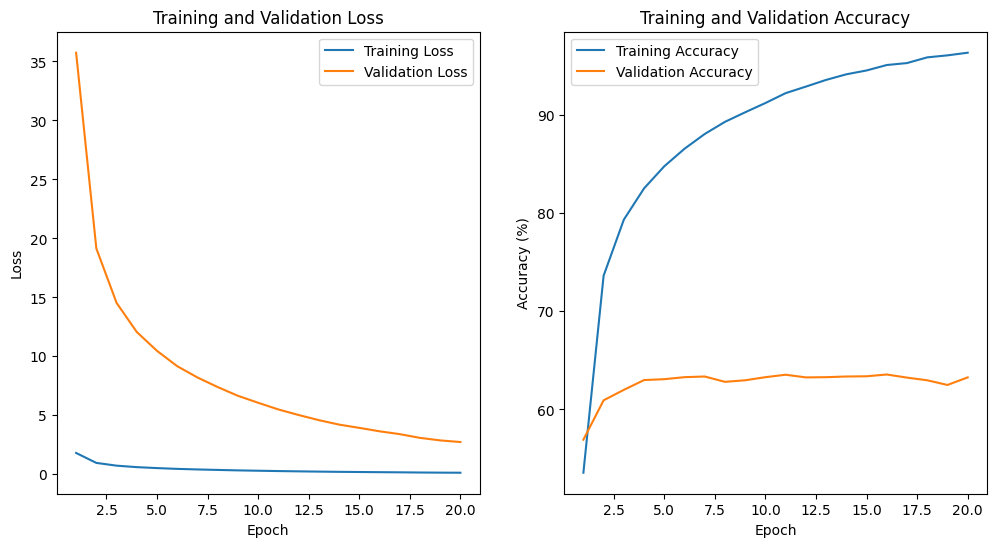

In [2]:
train_model(model, criterion, optimizer, num_epochs=20)

Evaluating: 100%|████████████████████████████████████████████████████████████████████| 198/198 [04:06<00:00,  1.25s/it]


Accuracy on test set: 63.66%
Classification Report:
              precision    recall  f1-score   support

           0       0.21      0.23      0.22        60
           1       0.65      0.65      0.65       720
           2       0.80      0.78      0.79       660
           3       0.61      0.58      0.59       420
           4       0.95      0.91      0.93       690
           5       0.90      0.93      0.92       720
           6       0.97      0.89      0.93       270
           7       0.95      0.87      0.91       210
           8       0.75      0.84      0.79       150
           9       0.93      0.88      0.91       360
          10       0.64      0.50      0.56       390
          11       0.19      0.35      0.25        60
          12       0.51      0.53      0.52       750
          13       0.06      0.06      0.06        90
          14       0.28      0.19      0.23        90
          15       0.54      0.42      0.47       120
          16       0.21      

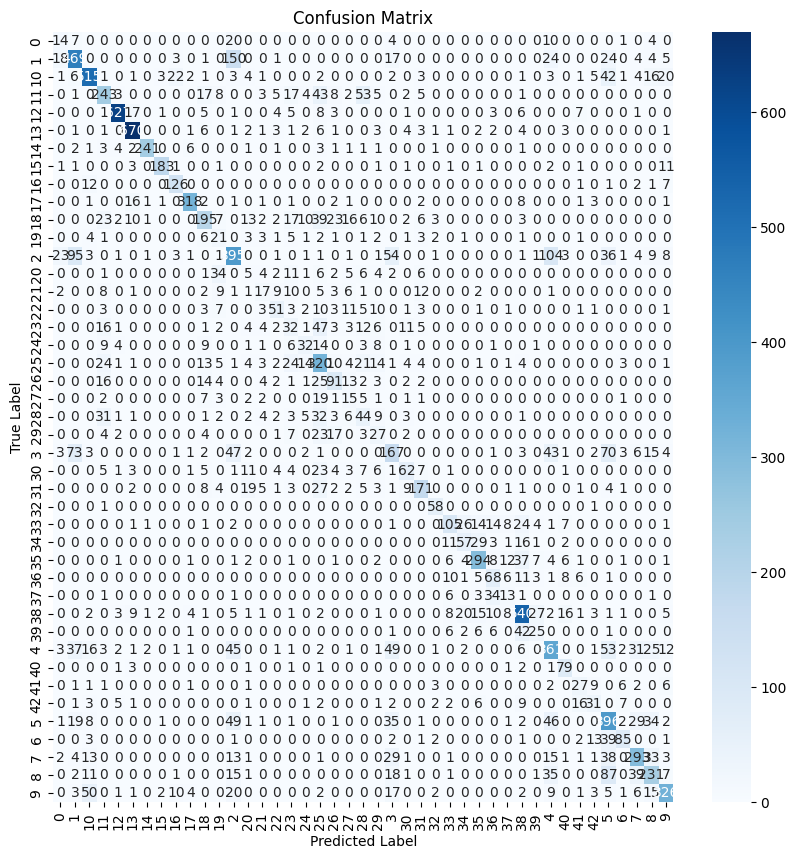

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
# Evaluate function
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    predictions = []
    ground_truths = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Evaluating'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            predictions.extend(predicted.cpu().numpy())
            ground_truths.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f'Accuracy on test set: {accuracy:.2f}%')

    # Confusion matrix
    cm = confusion_matrix(ground_truths, predictions)

    # Performance metrics
    print("Classification Report:")
    print(classification_report(ground_truths, predictions))

    # Plot confusion matrix
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

evaluate_model(model, test_loader)